**MODEL TO DETECT EMOTIONS FROM AUDIO SIGNALS**

The model uses the Ravdess and CREMAD datasets to learn classification of audio signals into the categories of emotions they convey. The audio is passed through certain augmentation procedures and then converted into a Mel Spectrogram. The spectrogram is then put into suitable CNN model to build the classifier model.

Arrangements to make use of the kaggle dataset

In [2]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=17b653623e024991334a65aa14fea6fd019128241f0447aead82a167a73ba51a
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [4]:
import os
os.makedirs('/root/.kaggle',exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

*The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.*

*Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D)*

In [9]:
!kaggle datasets download -d ejlok1/cremad

cremad.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 96% 413M/429M [00:01<00:00, 306MB/s]
100% 429M/429M [00:01<00:00, 294MB/s]


In [7]:
import zipfile
with zipfile.ZipFile('/content/ravdess-emotional-speech-audio.zip','r') as zip_ref:
  zip_ref.extractall('/content/ravdess')

In [10]:
with zipfile.ZipFile('/content/cremad.zip','r') as zip_ref:
  zip_ref.extractall('/content/cremad')

Ignore unnecessary warnings

In [11]:
import sys
import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
  warnings.filterwarnings("ignore", category=DeprecationWarning)

Importing the required libraries

In [12]:
import pandas as pd
import numpy as np

In [13]:
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
from IPython.display import Audio

In [15]:
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

Creating paths

In [16]:
Ravdess = "/content/ravdess/audio_speech_actors_01-24/"
Crema = "/content/cremad/AudioWAV/"

Extracting info from the database Ravdess

In [17]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
file_gender = []
for i in ravdess_directory_list:
    actor = os.listdir(Ravdess+i)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + i + '/' + file)
        gender=int(part[6])
        if gender%2==0:
            file_gender.append('female')
        else:
            file_gender.append('male')
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# path_df = pd.DataFrame(file_path, columns=['Path'])
# Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

RAV_df = pd.DataFrame(file_emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(file_gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
#RAV_df['Path']= file_path
RAV_df = pd.concat([RAV_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()



,count
labels,
male_neutral,144
female_neutral,144
male_disgust,96
male_sad,96
male_happy,96
male_fear,96
male_surprise,96
male_angry,96
female_surprise,96


Extracting info from the database Cremad

In [18]:
cremad_directory_list = os.listdir(Crema)
file_emotion = []
file_path = []
file_gender = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in cremad_directory_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    file_gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        file_emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        file_emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        file_emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        file_emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        file_emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        file_emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        file_emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        file_emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        file_emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        file_emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        file_emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        file_emotion.append('female_neutral')
    else:
        file_emotion.append('Unknown')
    file_path.append(Crema + i)

CREMA_df = pd.DataFrame(file_emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()


,count
labels,
male_sad,671
male_angry,671
male_fear,671
male_disgust,671
male_happy,671
female_disgust,600
female_fear,600
female_sad,600
female_happy,600


combining the data

In [19]:
data_path = pd.concat([RAV_df, CREMA_df,], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,labels,source,path
0,male_disgust,RAVDESS,/content/ravdess/audio_speech_actors_01-24/Act...
1,male_sad,RAVDESS,/content/ravdess/audio_speech_actors_01-24/Act...
2,male_sad,RAVDESS,/content/ravdess/audio_speech_actors_01-24/Act...
3,male_happy,RAVDESS,/content/ravdess/audio_speech_actors_01-24/Act...
4,male_disgust,RAVDESS,/content/ravdess/audio_speech_actors_01-24/Act...


seeing the distribution

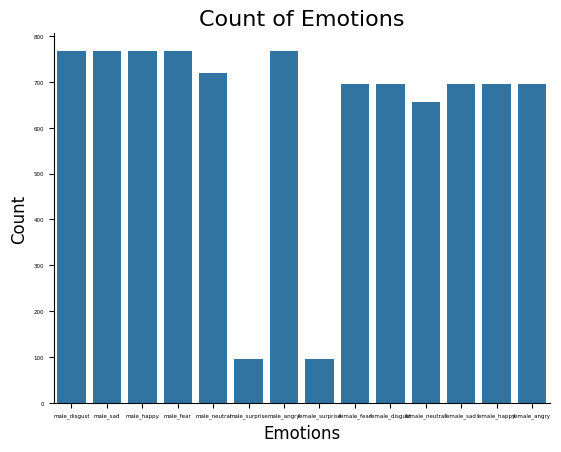

In [20]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tick_params(axis='both', which='major', labelsize=4)
plt.show()

Data Augmentation steps

In [21]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

The Mel Spectrogram

In [22]:
def mel_spectrogram(data):
    result = np.array([])
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

Passing the data through the augmentation functions and obtaining mel spectrograms for the audios

In [23]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = mel_spectrogram(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = mel_spectrogram(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = mel_spectrogram(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

separating learning and target columns

In [26]:
X, Y = [], []
for path, emotion in zip(data_path.path, data_path.labels):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [27]:
len(X), len(Y), data_path.path.shape

(26646, 26646, (8882,))

The Dataframe

In [28]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,labels
0,0.000020,0.000102,0.010556,0.019716,0.011948,0.019408,0.024388,0.011622,0.006429,0.007521,...,0.000033,0.000031,0.000024,0.000024,0.000023,0.000036,0.000040,0.000021,1.716188e-06,male_disgust
1,0.000040,0.000122,0.010575,0.019757,0.011993,0.019549,0.024587,0.011667,0.006439,0.007650,...,0.000056,0.000053,0.000046,0.000048,0.000045,0.000056,0.000060,0.000042,2.439840e-05,male_disgust
2,0.000008,0.000010,0.003931,0.011702,0.002505,0.003535,0.004455,0.002148,0.001550,0.001444,...,0.000004,0.000006,0.000010,0.000007,0.000005,0.000005,0.000005,0.000004,5.091677e-07,male_disgust
3,0.000047,0.000036,0.000014,0.000295,0.020374,0.108125,0.096671,0.076711,0.072883,0.028929,...,0.000139,0.000262,0.000331,0.000276,0.000287,0.000256,0.000264,0.000142,1.233393e-05,male_sad
4,0.000083,0.000068,0.000057,0.000346,0.020518,0.108264,0.096815,0.076948,0.073077,0.029132,...,0.000183,0.000310,0.000377,0.000326,0.000331,0.000300,0.000310,0.000189,5.645066e-05,male_sad


In [33]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Adjusting y for multiple classification

In [35]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

Splitting the data

In [68]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19984, 128), (19984, 14), (6662, 128), (6662, 14))

Scaling

In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19984, 128), (19984, 14), (6662, 128), (6662, 14))

Making the data fit dimensionally

In [70]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19984, 128, 1), (19984, 14), (6662, 128, 1), (6662, 14))

The model framework

In [71]:
import tensorflow as tf

In [72]:
from keras.layers import Activation, LSTM
from keras.layers import Dropout

In [73]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(x_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_49 (Conv1D)                   │ (None, 128, 256)            │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_50 (Conv1D)                   │ (None, 128, 256)            │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_46 (Activation)           │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 16, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_51 (Conv1D)                   │ (None, 16, 128)             │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_47 (Activation)           │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_52 (Conv1D)                   │ (None, 16, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_48 (Activation)           │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 16, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_49 (Activation)           │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_54 (Conv1D)                   │ (None, 16, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 16, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 2, 64)               │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_51 (Activation)           │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,284,494 (4.90 MB)

 Trainable params: 1,283,726 (4.90 MB)

 Non-trainable params: 768 (3.00 KB)

Training

In [75]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(x_train, y_train, batch_size=16, epochs=85, validation_data=(x_test, y_test))

Epoch 1/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.2189 - loss: 2.2573 - val_accuracy: 0.2558 - val_loss: 2.2540
Epoch 2/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2543 - loss: 2.1386 - val_accuracy: 0.2820 - val_loss: 2.1248
Epoch 3/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2791 - loss: 2.0344 - val_accuracy: 0.2971 - val_loss: 2.0569
Epoch 4/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3016 - loss: 1.9541 - val_accuracy: 0.3262 - val_loss: 1.9885
Epoch 5/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3165 - loss: 1.9013 - val_accuracy: 0.3155 - val_loss: 1.9467
Epoch 6/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3231 - loss: 1.8746 - val_accuracy: 0.3326 - val_loss: 1.9121
Epoch 7/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3324 - loss: 1.8397 - val_accuracy: 0.3482 - val_loss: 1.9081
Epoch 8/85
1249/1249 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3410 - loss: 1.8150

Predictions

In [76]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


The gender separation was important for training and classification but since in the end we only want the emotions to be matched, the suitable adjustments need to be made.

In [77]:
for i in range(0,len(y_pred)):
  if y_pred[i] == 'male_neutral'or y_pred[i] == 'female_neutral':
    y_pred[i] = 'neutral'
  elif y_pred[i] == 'male_happy' or y_pred[i] == 'female_neutral':
     y_pred[i]= 'happy'
  elif y_pred[i] == 'male_sad' or y_pred[i] == 'female_sad':
     y_pred[i] = 'sad'
  elif y_pred[i] == 'male_angry' or y_pred[i] == 'female_angry':
     y_pred[i] = 'angry'
  elif y_pred[i] == 'male_surprise' or y_pred[i] == 'female_surprie':
     y_pred[i]='surprise'
  elif y_pred[i] == 'male_fear' or y_pred[i] == 'female_fear':
     y_pred[i]='fear'
  elif y_pred[i] == 'male_disgust' or y_pred[i] == 'female_disgust':
     y_pred[i]='disgust'

In [78]:
for i in range (0,len(y_test)):
  if y_test[i] == 'male_neutral'or y_test[i] == 'female_neutral':
    y_test[i] = 'neutral'
  elif y_test[i] == 'male_happy' or y_test[i]== 'female_happy':
    y_test[i] = 'happy'
  elif y_test[i] == 'male_sad' or y_test[i] == 'female_sad':
     y_test[i] = 'sad'
  elif y_test[i] == 'male_angry' or y_test[i] == 'female_angry':
     y_test[i] = 'angry'
  elif y_test[i] == 'male_surprise' or y_test[i] == 'female_surprie':
     y_test[i]='surprise'
  elif y_test[i] == 'male_fear' or y_test[i] == 'female_fear':
     y_test[i]='fear'
  elif y_test[i] == 'male_disgust' or y_test[i] == 'female_disgust':
     y_test[i]='disgust'

Checking predictions on testing data

In [79]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,angry
1,disgust,disgust
2,disgust,disgust
3,sad,fear
4,happy,sad
5,neutral,neutral
6,neutral,happy
7,neutral,disgust
8,fear,angry
9,fear,disgust
